In [8]:
import sys
sys.path.append("../..")
import torch
from pathlib import Path
import scipy
from lru.architectures import DLRU, DLRUConfig
import matplotlib.pyplot as plt
import torchid.metrics # pip install pytorch-ident

In [9]:
#%matplotlib widget

In [10]:
# Load data (to be embedded)
data_folder = ("F16GVT_Files", "BenchmarkData")

#file_name = "F16Data_SineSw_Level5.mat"
#
#file_name = "F16Data_FullMSine_Level7.mat"
#file_name = "F16Data_FullMSine_Level5.mat"


#file_name = "F16Data_FullMSine_Level4_Validation.mat"
file_name = "F16Data_FullMSine_Level6_Validation.mat"
#file_name = "F16Data_SineSw_Level6_Validation.mat"
file_path = Path(*data_folder) / file_name
data = scipy.io.loadmat(file_path)

In [11]:
run = "ckpt_large_no_reg"
#run = "ckpt_large_reg_modal"
#run = "ckpt_large_reg" # lasso on eigs abs val
#run = "ckpt_large_no_reg_last"
#run = "ckpt_small_no_reg"
#run = "ckpt_small_reg"

In [12]:
ckpt = torch.load(Path("ckpt")/ f"{run}.pt", map_location="cpu")
cfg = ckpt["cfg"]
scaler_u = ckpt["scaler_u"]
scaler_y = ckpt["scaler_y"]

/Users/marco.forgione/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
u_test = data["Force"].T # Or force
y_test = data["Acceleration"].T

In [14]:
# Load model
cfg = ckpt["cfg"]
config = DLRUConfig(d_model=cfg.d_model,d_state=cfg.d_state, n_layers=cfg.n_layers, ff=cfg.ff)
model = DLRU(1, 3, config)
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [15]:
sum(map(torch.numel, model.parameters()))

199153

In [16]:
ut = torch.tensor(scaler_u.transform(u_test)).unsqueeze(0).float()
with torch.no_grad():
    y_test_hat = model(ut, mode="scan").squeeze(0).to("cpu").numpy()

y_test_hat = scaler_y.inverse_transform(y_test_hat)

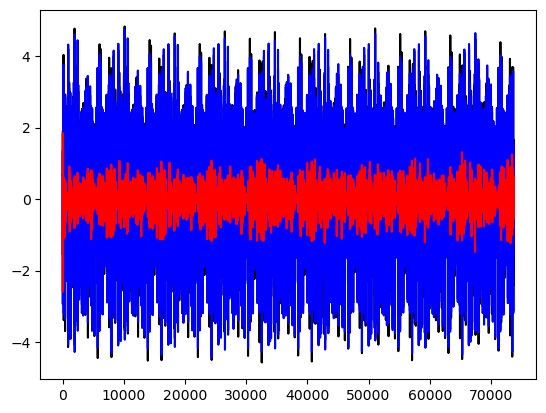

In [17]:
plt.figure()
plt.plot(y_test[:, 0], "k")
plt.plot(y_test_hat[:, 0], "b")
plt.plot(y_test_hat[:, 0] - y_test[:, 0], "r")

In [18]:
fit = torchid.metrics.fit_index(y_test, y_test_hat)
rmse = torchid.metrics.rmse(y_test, y_test_hat)
nrmse = torchid.metrics.nrmse(y_test, y_test_hat)


print(f"{fit=} \n{rmse=} \n{nrmse=}")

fit=array([86.55459738, 90.08863281, 76.25738613]) 
rmse=array([0.18009912, 0.16724906, 0.36776594]) 
nrmse=array([0.13445403, 0.09911367, 0.23742614])


Results on "F16Data_FullMSine_Level6_Validation.mat", non-regularized model:

fit=array([86.69775422, 90.17415163, 76.63687079]) 

rmse=array([17.81815528, 16.58059711, 36.18878376]) 

nrmse=array([0.13302246, 0.09825848, 0.23363129])

In [19]:
fit.mean()

84.3002054396424

(0.0, 0.2)

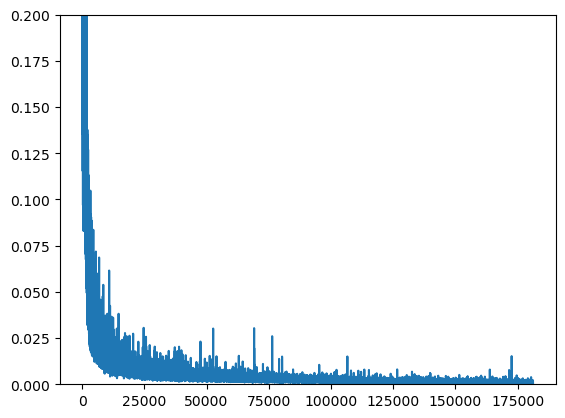

In [20]:
plt.figure()
plt.plot(ckpt["LOSS"])
plt.ylim([0.0, 0.2])

In [21]:
matlab_dict = {}
for idx, block in enumerate(model.blocks):
    A, B, C, D = block.lru.ss_real_matrices()
    matlab_dict[f"layer{idx}"] = {"A": A, "B": B, "C": C, "D": D}

In [22]:
# import scipy.io as sio
# sio.savemat(f"lti_matrices_{run}.mat", matlab_dict)

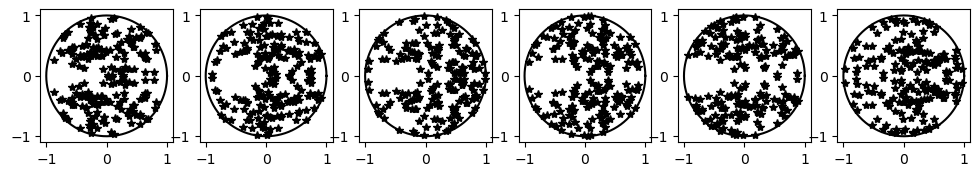

In [23]:
import numpy as np
#plt.figure(figsize=(2*config.n_layers+2, 2))
fig, ax = plt.subplots(1, config.n_layers, figsize=(2*config.n_layers, 2.5))
t = np.linspace(0, 2*np.pi, 1000)
for idx, layer in enumerate(model.blocks):#range(config.n_layers):
    lambdas, B, C, D = layer.lru.ss_params()
    lambdas = lambdas.detach()
    ax[idx].plot(np.cos(t), np.sin(t), "-k")
    ax[idx].plot(lambdas.real, lambdas.imag, "k*")#lambdas.real
    ax[idx].plot(lambdas.real, -lambdas.imag, "k*")#lambdas.real
    ax[idx].set_box_aspect(1)

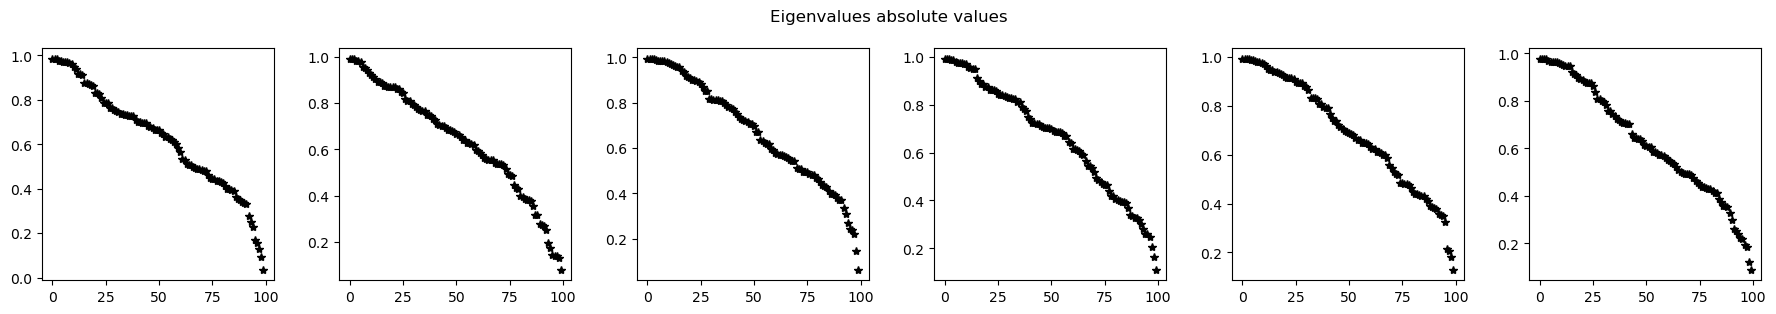

In [24]:
fig, ax = plt.subplots(1, config.n_layers, figsize=(3 * config.n_layers, 3.0))
fig.suptitle("Eigenvalues absolute values")
for idx, layer in enumerate(model.blocks):  # range(config.n_layers):
    lambdas, *_ = layer.lru.ss_params()
    lambdas = lambdas.detach().numpy()
    ax[idx].plot(np.sort(np.abs(lambdas))[::-1], "k*")  # lambdas.real
    ax[idx].set_box_aspect(1)
plt.tight_layout()